This notebook is a part of article [CardIO framework for deep research of electrocardiograms](https://medium.com/data-analysis-center/cardio-framework-for-deep-research-of-electrocardiograms-2a38a0673b8e) and contains code blocks from this article.

Some general imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

sys.path.append(os.path.join("..", "..", ".."))
import ecg.dataset as ds
from ecg.batch import ModelEcgBatch
from ecg.models.metrics import classification_report

Using TensorFlow backend.


Create indices from filenames

In [2]:
# import CardIO.dataset as ds
# index = ds.FilesIndex(path="ecg/tests/data/*.hea", no_ext=True, sort=True)
index = ds.FilesIndex(path="/notebooks/e_illarionov/ecg_master/ecg/ecg/tests/data/*.hea", no_ext=True, sort=True)

Check which indices are in list of indices

In [3]:
print(index.indices)

['A00001' 'A00002' 'A00004' 'A00005' 'A00008' 'A00013']


Create dataset

In [4]:
# from CardIO.batch import ModelEcgBatch
# eds = ds.Dataset(index, batch_class=ModelEcgBatch)
eds = ds.Dataset(index, batch_class=ModelEcgBatch)

Generate batch

In [5]:
batch = eds.next_batch(batch_size=2)

Fill batch with data

In [6]:
batch_with_data = batch.load(fmt="wfdb", components=["signal", "meta"])

Plot short segment of ECG with index 'A00001'

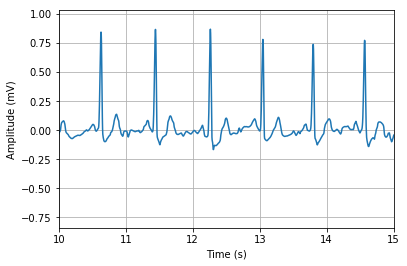

In [11]:
signal = batch_with_data['A00001'].signal.ravel()
time = np.arange(len(signal)) / batch_with_data['A00001'].meta['fs']
plt.plot(time, signal)
plt.xlabel('Time (s)'), plt.ylabel('Amplitude (mV)')
plt.xlim([10, 15]), plt.grid()
plt.show()

Run pipeline for detection of QRS intervals, P-waves and T-waves

In [8]:
# from CardIO.pipelines import calc_ecg_parameters
# res = (eds >> calc_ecg_parameters()).run(batch_size=2, n_epochs=1)

f = np.load('/notebooks/e_illarionov/ecg_master/ecg/ecg/tests/A00001_annotation.npz')
hmm = f['arr_0']

def find_intervals_borders(hmm_annotation, inter_val):
    """ Finds starts and ends of the intervals with values from inter_val.

    Parameters
    ----------
    hmm_annotation : numpy.array
        Annotation for the signal from hmm_annotation model.
    inter_val : array_like
        Values that form interval of interest.

    Returns
    -------
    starts : numpy.array
        Indices of the starts of the intervals.
    ends : numpy.array
        Indices of the ens of the intervals.
    """
    intervals = [1 if x in inter_val else 0 for x in hmm_annotation]
    masque = np.diff(intervals)
    starts = (np.argwhere(masque == 1).flatten() + 1)
    ends = (np.argwhere(masque == -1).flatten() + 1)
    if hmm_annotation[0] in inter_val:
        ends = ends[1:]
    if hmm_annotation[-1] in inter_val:
        starts = starts[:-1]
    return starts.tolist(), ends.tolist()

qrs = find_intervals_borders(hmm, [0, 1, 2])
pq = find_intervals_borders(hmm, [14, 15, 16])
qt = find_intervals_borders(hmm, [5, 6, 7, 8, 9, 10])

Plot ECG signal with detected QRS intervals, P-waves and T-waves

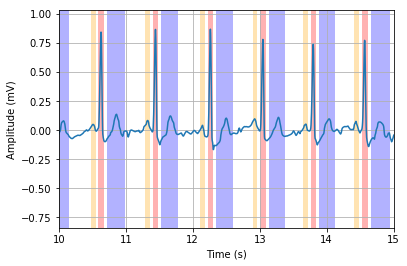

In [10]:
plt.plot(time, signal)
for xmin, xmax in np.array(qrs).T:
    plt.axvspan(time[xmin], time[xmax], facecolor='red', alpha=0.3)
for xmin, xmax in np.array(pq).T:
    plt.axvspan(time[xmin], time[xmax], facecolor='orange', alpha=0.3)
for xmin, xmax in np.array(qt).T:
    plt.axvspan(time[xmin], time[xmax], facecolor='blue', alpha=0.3)
plt.xlabel('Time (s)'), plt.ylabel('Amplitude (mV)')
plt.xlim([10, 15]), plt.grid()
plt.show()

Run pipeline for prediction of atrial fibrillation

In [14]:
# from CardIO.pipelines import af_prediction_pipeline

def af_prediction_pipeline():
    model_path = "/notebooks/Kuvaev/dirichlet/"
    last_model_path = tf.train.latest_checkpoint(model_path)
    model_config = {
        "graph_path": last_model_path + ".meta",
        "checkpoint_path": last_model_path,
        "classes_path": last_model_path + ".dill"
    }
    config = {"dirichlet_pretrained": model_config}
    
    return (ds.Pipeline(config=config)
              .init_model("dirichlet_pretrained")
              .load(fmt="wfdb", components=["signal", "meta"])
              .flip_signals()
              .split_signals(2048, 512)
              .predict_on_batch("dirichlet_pretrained", predictions_var_name="predictions_list")
              .run(shuffle=False, drop_last=False, lazy=True))

pipeline = af_prediction_pipeline()
(eds >> pipeline).run(batch_size=2, n_epochs=1)
res = pipeline.get_variable("predictions_list")

INFO:tensorflow:Restoring parameters from /notebooks/Kuvaev/dirichlet/dirichlet-34000


Get predicted probalilities for artrial fibrillation

In [15]:
print([x['target_pred']['A'] for x in res])

[0.020612197, 0.61115807, 0.024541298, 0.016741527, 0.027645184, 0.87172413]
